# Simple Demonstration of Hamiltonian Monte Carlo (HMC)

## Preliminaries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import hmc_Lab as hmc
%matplotlib inline

## The "Distribution"

The distribution used here is a contrived two-dimensional one, but un-normalised.
That is, it is in the form $P^\ast(x_1, x_2)$.

To run HMC, we must define the "energy" and gradient functions first.
- `energy_func`: the energy function is $-\log P^\ast(x_1, x_2)$,
- `energy_grad`: the gradient function returns an array containing
the partial derivatives of the energy function with respect to the parameters,
which are $x_1$ and $x_2$ here,
- this may take a little bit of working out,
- it is always worth checking for errors by using the `checkgrad` functionality
(demonstrated below).

## The Error Function
This is the negative log-probability of our un-normalised distribution. This example here
is entirely artificial. It is Gaussian in one axis, and Gaussian modulated by a harmonic
function in the other.

Remember that energy is *negative* log probability, hence the negated return value.

In [2]:
def energy_func(x, f):
    # Simulating some unknown log-probability
    p0 = -x[0]**2/2
    p1 = -x[1]**2/2 + np.log(2+np.cos(f*x[1]))
    lgp = p0 + p1
    return -lgp

## The Gradient Function
This an array containing the partial derivatives of the energy function with respect to
$x_1$ and $x_2$. It generally will need to be worked out by hand. In this case, `g[0]`
is trivial, while `g[1]` needed application of the chain rule.

In [3]:
def energy_grad(x, f):
    g = np.empty(2)
    g[0] = x[0]
    g[1] = x[1] + f*np.sin(f*x[1]) / (2+np.cos(f*x[1]))
    return g

## Visualising the Distribution
Before we run the sampler, let's visualise the distribution over an appropriate
grid of values.

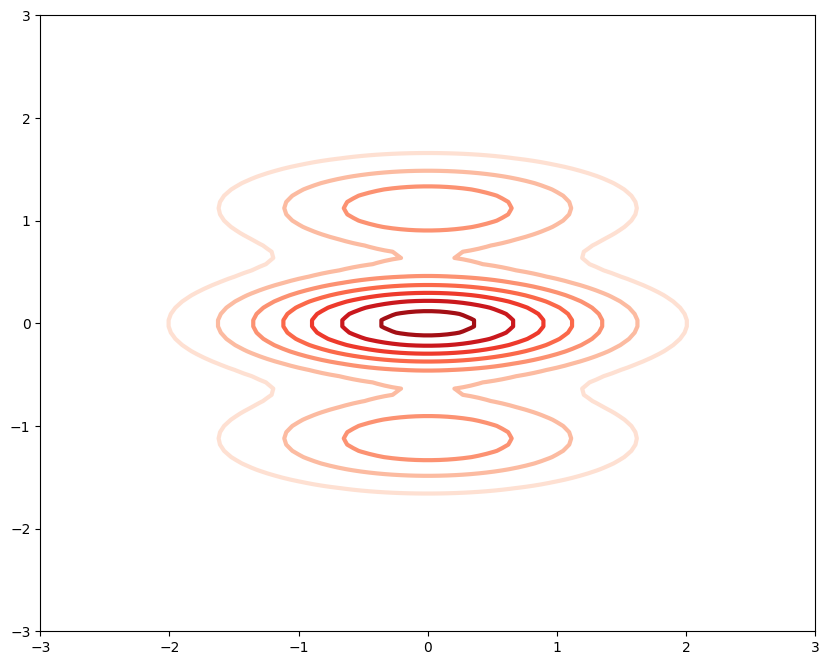

In [4]:
f = 5  # The "frequency" argument for the energy, used here to demonstrate use of "args"
# Plotting parameters
fsz = (10,8)
gsz = 100
lim = 3
#
gx = np.linspace(-lim, lim, gsz)
GX, GY = np.meshgrid(gx, gx)
Gsz = GX.size
G = np.hstack((GX.reshape((Gsz, 1)), GY.reshape((Gsz, 1))))
#
plt.figure(figsize=fsz)
P = np.asarray([np.exp(-energy_func(g, f)) for g in G])
plt.contour(GX, GY, P.reshape((gsz, gsz)), cmap='Reds', linewidths=3, zorder=1);

## Set up the Sampler

First, to run the sampler we must pass in the energy and gradient functions as defined above.

As well as `x` which is to be sampled, those functions need the "frequency" parameter `f`
(which is fixed). This is passed as `args` to the sampler (and subsequently forwarded
internally to `energy_func` and `energy_grad`). When sampling in Bayesian regression contexts,
you will need to pass the data set there. *e.g.* `args = [x_train, t_train]`.

Additionally, there are some further arguments we must specify:

- `R`: the number of samples desired
- `L`: number of simulation steps; for this simple case, 20 is easily enough
- `eps`: simulation step length; set by trial-and-error to give approx. 90% acceptance
- `burn`: simply set to `R/10`
- `checkgrad`: set to true to test the consistency of `e_func` and `e_grad`

In summary: with `L` chosen roughly in accordance with the complexity of the distribution,
only `eps` really needs to be adjusted.

## Gradient Check
In this example, to demonstrate it more clearly, we run the gradient check separately
in advance (you would normally want to do it automatically in `sample`).

Running `gradient_check` below will calculate a numerical estimate of the gradient
(using `energy_func`) and compare it with the analytic value (from `energy_grad`) for each parameter
individually. Because it is
a numerical estimate, there will always be a small discrepancy, but if this becomes large,
it likely indicates some error.

The most informative column in the output below is probably `Acc.`,
which gives a logarithmic (base-10)
measure of relative accuracy. For example, an accuracy of "9" implies
an error less than one part in $10^9$. Anything lower than 6 might indicate a minor error
(in maths and/or code), and anything less than 4 almost certainly does.

In [5]:
#
# Initial state: something random and sensible
x0 = np.random.normal(size=2)
hmc.gradient_check(x0, energy_func, energy_grad, f)

Calc.         Numeric       Delta         Acc.
    0.727384      0.727384  -9.593992e-12  11
    -3.24666      -3.24666  -1.020339e-11  12


## Run the Sampler!

At every `R/10` steps (plus after burn-in), the sampler indicates the progress so far
along with the cumulative acceptance rate to that point. The sampler parameters are
also summarised at the end.

|----------|  0% accepted [ 4 secs to go ]
|#---------| 91% accepted [ 4 secs to go ]
|##--------| 91% accepted [ 3 secs to go ]
|###-------| 91% accepted [ 3 secs to go ]
|####------| 91% accepted [ 2 secs to go ]
|#####-----| 91% accepted [ 2 secs to go ]
|######----| 91% accepted [ 1 secs to go ]
|#######---| 91% accepted [ 1 secs to go ]
|########--| 91% accepted [ 1 secs to go ]
|#########-| 91% accepted [ 0 secs to go ]
|##########| 91% accepted [ 0 secs to go ]
HMC: R=10000 / L=20 / eps=0.3 / Accept=91.0%


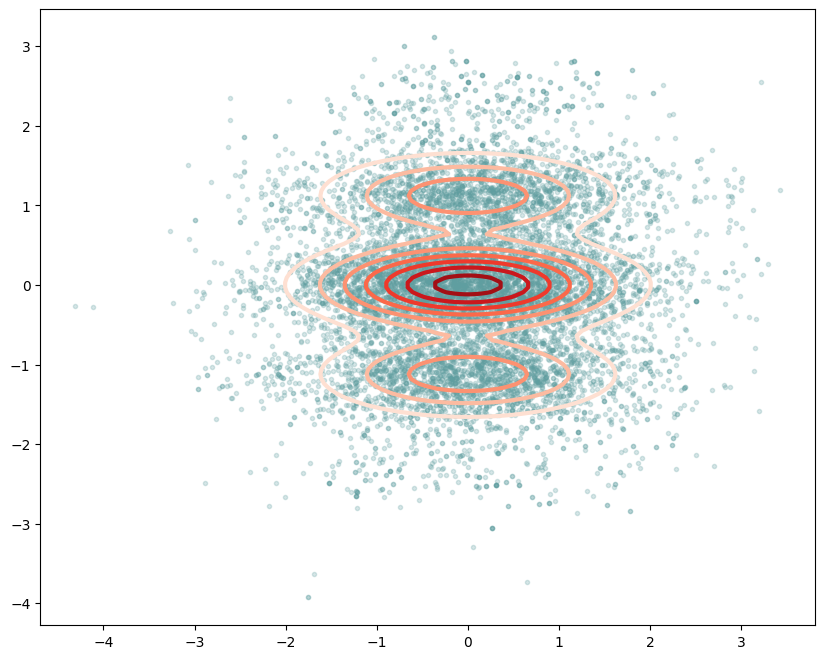

In [6]:
#
np.random.seed(seed=1)  # For reproducibility
R = 10000  # More than really needed, but produces a nice dense plot
burn = int(R/10)  # A reasonable rule-of-thumb
L = 20  # OK here (should be larger in regression sampling)
eps = 0.3  # Trial-and-error ... feel free to experiment!
#
S, *_ = hmc.sample(x0, energy_func, energy_grad, R, L, eps, burn=burn, checkgrad=False, args=[f])
#
plt.figure(figsize=fsz)
plt.plot(S[:, 0], S[:, 1], '.', ms=6, color='CadetBlue', alpha=0.25, zorder=0)
plt.contour(GX, GY, P.reshape((gsz, gsz)), cmap='Reds', linewidths=3, zorder=1);